<div align=center class="alert alert-block alert-info">
    <h1>IBM Quantum Challenge アフリカ:</h1>
        <h1>量子化学でHIVの課題を解く</h1>
</div>

<img src="./resources/HIV-1_capsid_wikipedia.png"/>

<div align=center class="alert alert-block alert-info">
    <h1>目次</h1>
</div>

| 目次  |
|:-|
||
| 水素分子での例題  |
|[序文](#preface)|
|[はじめに](#intro)|
|[Step 1 : 分子幾何学の定義](#step_1)|
|[Step 2 : 量子ビットハミルトニアンの計算](#step_2)|
|[Step 2a: フェルミオンのハミルトニアンの構築](#step_3)|
|[Step 2b: 量子ビットハミルトニアンへの変換の準備](#step_2b)|
|[Step 3 : 変分法量子固有値ソルバー(VQE)の設定](#step_3)|
|[Step 3a: VQEのV（変分形式、試行状態）について](#step_3a)|
|[Step 3b: VQEのQ（量子の環境）について](#step_3b)|
|[Step 3c: VQEの初期化](#step_3c)|
|[Step 4 : 基底状態の解法](#step_4)|
||
|[HIVチャレンジ](#challenge)|
|[1. Step 1の改良: 分子を変化させる](#refine_step_1)|
|[2. Step 2の改良: 量子量の削減](#refine_step_2)|
|[3. Step 4の改良: エネルギー曲面](#refine_step_4)|
|[4. Step 3aの改良](#refine_step_3a)|
||
|Exercises|
|[Exercise 3a: ブロッキングアプローチによるマクロ分子の分子定義](#exercise_3a)|
|[Exercise 3b: 古典-量子処理の概念問題 (複数からの選択式)](#exercise_3b)|
|[Exercise 3c: エネルギーランドスケープー結合するかしないか？](#exercise_3c)|
|[Exercise 3d: 反復回数の増加による効果](#exercise_3d)|
|[Exercise 3e: 自由形式：マクロ分子のエネルギー誤差を最小化するための最適なhardware_inspired_trialを見つけよう](#exercise_3e)|
|[量子化学の参考文献](#qresource)|

<h2><a id='preface'>序文</a></h2>

**HIVは、世界的に見ても公衆衛生上、非常に大きな課題となっているウイルスです。** その結果、栄養状態、健康へのアクセス、教育、研究費など、社会のさまざまな側面に影響を与えています。さらに、このウイルスは急速に変異し、異なる株が異なる地域に分布していることも問題です。特に、HIV-1-CとHIV-2の株は、主にアフリカで多く見られます。資金面での格差により、アフリカ株の治療法の研究は他のプログラムに比べて遅れています。アフリカの研究者たちは、この不均衡を解消しようと努力していますが、彼らのツールキットに量子コンピューティングなどの最新技術を加えることを検討すべきです。

**量子コンピューターは、医薬品の設計を飛躍的に向上させます。** 特に、新しい抗レトロウイルス剤を設計するためには、**化学シミュレーション** を行って、抗レトロウイルス剤がウイルスのタンパク質と結合することを確認することが重要です。このようなシミュレーションは、従来のスーパーコンピューターでは難しく、効果がないこともありました。しかし、量子コンピューターを使えば、より正確なシミュレーションが可能になり、よりよい薬剤設計のワークフローが実現すると期待されています。

詳細：抗レトロウイルス薬は、ウイルスのポリタンパク質をより小さなタンパク質に切断してパッケージ化するプロテアーゼと呼ばれるウイルスタンパク質に結合してブロックする薬剤です。プロテアーゼは、化学的なハサミと考えることができます。抗レトロウイルス剤は、ハサミの切断能力を阻害する粘着性の障害物と考えることができます。プロテアーゼが阻害されると、ウイルスは自分自身のコピーを増やすことができません。

ウイルスのプロテアーゼに変異があると、ある抗レトロウイルスの結合傾向が変わります。そのため、変異が起きて抗レトロウイルスがうまく結合できなくなった場合、抗レトロウイルスの分子を調整して再び強く結合できるようにすることが目標となります。

**この課題の主な目的は、抗レトロウイルス分子のトイモデルが、ウイルスのプロテアーゼのトイモデルと結合するかどうかを調べることです。**

この課題では、 **最先端のハイブリッド古典-量子組み込み化学モデリング** を導入し、古典的な近似とより正確な量子計算の間で作業負荷を分割することができます。

最後に、現在の量子コンピューティングに存在するノイズを考慮して最高のパフォーマンスを達成するために、（量子コンピューティングの基本を理解していなくても）量子化学アルゴリズムの設定を微調整する必要があります。

*HIVの感染経路や抗レトロウイルス治療の仕組みなどを解説したビデオです*:

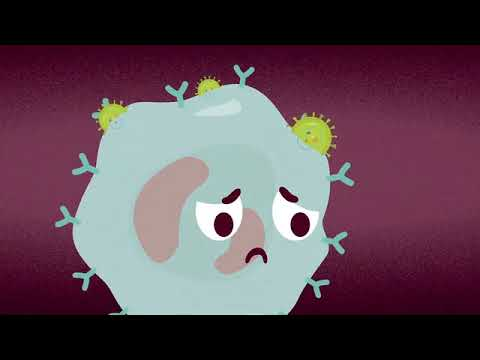

In [1]:
from IPython.display import display, YouTubeVideo
YouTubeVideo('cSNaBui2IM8')

<div align=center class="alert alert-block alert-success">
    <h1>例題：宇宙で最も単純な分子の基底状態エネルギーを計算する</h1>
</div>

*関連するパッケージをインポートする*

In [2]:
from qiskit import Aer

from qiskit_nature.drivers import PySCFDriver, UnitsType, Molecule
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.converters.second_quantization import QubitConverter

from qiskit_nature.transformers import ActiveSpaceTransformer
from qiskit_nature.algorithms import GroundStateEigensolver, BOPESSampler
from qiskit.algorithms import NumPyMinimumEigensolver

from qiskit.utils import QuantumInstance

from qiskit_nature.circuit.library.ansatzes import UCCSD
from qiskit_nature.circuit.library.initial_states import HartreeFock
from qiskit.circuit.library import TwoLocal

from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA

from functools import partial as apply_variation_to_atom_pair
import numpy as np
import matplotlib.pyplot as plt

<h2><a id='intro'>はじめに</a></h2>

HIVチャレンジでは，抗レトロウイルス分子のトイモデルがプロテアーゼ分子のトイモデルと結合し，それによって破壊されるかどうかを調査することが課題となっています。結合が成功したかどうかは、分子が近接している（単一のマクロ分子を形成している）場合、離れている場合に比べて、分子の全基底状態エネルギーが低いかどうかで決まります。

全基底状態エネルギーとは、電子と原子核の配置に関するエネルギーの総和です。原子核エネルギーは古典計算で簡単に計算できますが、電子分布のエネルギー（すなわち、分子のスピン軌道の占有率）は非常に計算が難しく、量子コンピューターが必要となります。

例題のチュートリアルでは、まず簡単な分子の基底状態のエネルギーを計算し、より複雑な設定についてはチャレンジ編で行います。

ある構造の分子の基底状態は、原子核の位置と、原子核の周りの電子の分布で構成されています。原子核と原子核、原子核と電子、電子と電子の引力と斥力が**ハミルトニアン**と呼ばれる行列に取り込まれます。原子核は電子に比べて比較的質量が大きいため、電子よりも遅い時間軸で動きます。このため、計算を2つに分けることができます。すなわち、原子核を止めて電子分布を計算した後、全エネルギー分布が最小になるまで、原子核を移動させて電子分布を再計算するのです：

<div class="alert alert-block alert-warning">
<b>アルゴリズム: Find_total_ground_state（基底状態を探す）</b>

原子核を静止する
    
グリッドが完成するか、total_energy に変化がなくなるまで繰り返す：
    
  - 電子の基底状態を計算する 
    
  - total_energy = (原子核の反発力 + 電子のエネルギー)
    
  - （グリッド内のまたは勾配に従って）原子核を動かす

return total_energy
</div>

この例題では、単純に原子核の位置を固定していますが、後のチャレンジの章では、抗レトロウイルスとプロテアーゼ分子の間の1次元の分子間距離を変化させることで、抗レトロウイルスがプロテアーゼ分子に接近して結合しようとしていることを表現しています。

<h2><a id='step_1'>Step 1: 分子の構造を定義する</a></h2>

このチュートリアルでは、可能な限り簡単ですが自明ではない分子を使用します：H$_2$は、水素分子です。

<img src="./resources/h2.png"/>


*まず最初に行うことは、各原子核の位置を固定することです。これはpythonの原子核のリストとして指定され、各原子核（リスト）には、原子の種類に対応した文字列とその3次元座標（別のリスト）が含まれます。また、全体の電荷を指定すると、その電荷を生成するために必要な電子の数をQiskitが自動的に計算します。*

In [3]:
hydrogen_molecule = Molecule(geometry=
                             [['H', [0., 0., 0.]],
                              ['H', [0., 0., 0.735]]],
                     charge=0, multiplicity=1)

<h2><a id='step_2'>Step 2: 量子ビットのハミルトニアンを計算する</a></h2>

原子核の位置が固定されると（原子核-原子核間の力は一時的に無関係になり）、量子コンピューター上で計算する必要があるハミルトニアンは、詳細な電子-電子相互作用だけになります。原子核-電子間および大まかな平均場電子-電子間の相互作用は、ハートリーフォック近似と呼ばれる方法で、古典計算機上で*許可された分子軌道*としてあらかじめ計算することができます。これらの許可された分子軌道と事前に計算されたものをかけ合わせ、 Qiskit は自動的に相互作用する電子-電子間の**フェルミオン分子軌道ハミルトニアン**(フェルミ演算子によるハミルトニアン)を生成します（第二量子化と呼ばれます）。分子軌道と掛け合わされる事前計算は、PySCFなどの古典的なパッケージによって行われ、いわゆる*ドライバー*を介してQiskitに接続されており、今回、私たちはPySCFDriverを使用します。

<h3><a id='step_3'>Step 2a: フェルミ演算子によるハミルトニアンを構築する</a></h3>

*ここでは，原子核-電子間および平均場相互作用を考慮した上で、分子軌道を計算するための古典的な化学コードとのインターフェースとなる「ドライバー」を指定します。`basis`オプションは、分子軌道を展開する基底セットを選択します。`sto3g`は最も小さい基底セットです。*


In [4]:
molecular_hydrogen_orbital_maker = PySCFDriver(molecule=hydrogen_molecule, unit=UnitsType.ANGSTROM, basis='sto3g')

<ipython-input-4-4c234653fc0d>:1: DeprecationWarning: The PySCFDriver class is deprecated as of version 0.2.0 and will be removed no sooner than 3 months after the release. Instead use the PySCFDriver class from qiskit_nature.drivers.second_quantization.pyscfd.
  molecular_hydrogen_orbital_maker = PySCFDriver(molecule=hydrogen_molecule, unit=UnitsType.ANGSTROM, basis='sto3g')


*QiskitにはElectronicStructureProblemという便利なクラスがあり、分子軌道を構築するためにドライバーを呼び出します。ElectronicStructureProblemをドライバーで初期化します（ドライバーにはすでに前のステップから分子情報が保存されています）。*

In [5]:
hydrogen_fermionic_hamiltonian = ElectronicStructureProblem(molecular_hydrogen_orbital_maker)

*ここでは、ElectronicStructureProblemオブジェクトに、フェルミオン分子軌道ハミルトニアン（フェルミ演算子によるハミルトニアン）の作成を進めるように指示しています（内部に保存されます）。*

In [6]:
second_q_op = hydrogen_fermionic_hamiltonian.second_q_ops()
print("古典パッケージの実行が完了しました。\nフェルミオン分子軌道ハミルトニアンが計算され、内部に保存されます。")
print("利用可能なHF情報の例: 軌道エネルギー", hydrogen_fermionic_hamiltonian._molecule_data_transformed.orbital_energies)
print(second_q_op[0])

古典パッケージの実行が完了しました。
フェルミオン分子軌道ハミルトニアンが計算され、内部に保存されます。
利用可能なHF情報の例: 軌道エネルギー [-0.58062892  0.67633625]
Fermionic Operator
register length=4, number terms=14
  (0.18093119978423128+0j) * ( +_0 -_1 +_2 -_3 )
+ (-0.18093119978423136+0j) * ( +_0 -_1 -_2 +_3 )
+ (-0.18093119978423136+0j) * ( -_0 +_1 +_2 -_3 )
+ (0.18093119978423142+0j) * ( -_0 +_1 -_2 +_3  ...


(このステップが明示的に実行されず、その出力が中間ステップで使用されない場合は、最終的なground_state solvingステップで自動的に実行されます)。

<h3><a id='step_2b'>Step 2b: 量子ビットによるハミルトニアンに変換する準備をする</a></h3>

ここでいう*フェルミオン*とは、電子の振る舞いを表す言葉です。量子コンピューターを使用するためには、電子（フェルミ演算子）を量子コンピューターの量子ビットにマッピングする必要があります。

複数のマッピング方法があり、それぞれに長所と短所があるので、試してみるとよいでしょう。

*ここでは、Jordan-Wigner Mapperと呼ばれる最も単純な量子ビットへのマッピング/変換方法を選択します。*

In [7]:
map_fermions_to_qubits = QubitConverter(JordanWignerMapper())
# 別の例：
# map_fermions_to_qubits = QubitConverter(BravyiKitaevMapper())

(注：マッパー（変換方法）を選択しただけで、まだ適用されていません。）

In [8]:
# フェルミ演算子によるハミルトニアンをパウリ演算子に変換（パウリ演算子を表示するために追加）
qubit_op = map_fermions_to_qubits.convert(second_q_op[0])
print(qubit_op)

-0.8105479805373279 * IIII
- 0.22575349222402374 * ZIII
+ 0.17218393261915554 * IZII
+ 0.12091263261776627 * ZZII
- 0.22575349222402374 * IIZI
+ 0.1746434306830045 * ZIZI
+ 0.16614543256382414 * IZZI
+ 0.17218393261915554 * IIIZ
+ 0.16614543256382414 * ZIIZ
+ 0.16892753870087912 * IZIZ
+ 0.12091263261776627 * IIZZ
+ 0.04523279994605784 * XXXX
+ 0.04523279994605784 * YYXX
+ 0.04523279994605784 * XXYY
+ 0.04523279994605784 * YYYY


<h2><a id='step_3'>Step 3:  変分量子固有値ソルバー(VQE)をセットする</a></h2>

さて、分子とその量子コンピューターへのマッピングを定義したところで、基底状態を解くためのアルゴリズムを選択する必要があります。よく知られているアプローチは2つあります。量子位相推定法（QPE）とVQEです。QPEはフォールト・トレラントな量子コンピューターが必要となり、まだ使えません。VQEは、短いDepthの量子回路を用いたイブリッド量子-古典手法であるため、現在のノイズの多い**Depth**に制限のある量子コンピューターに適しています。量子コンピューターの回路の*Depth*制限とは、ノイズによって結果が完全にかき消されてしまう前にしか、つまり、短時間しか計算が実行できないという制限です。

よって、私たちは、今のところはVQE法のみを検討します。さらに、VQEは構成を微調整することが多いので、エンドユーザーとして、量子ブラックボックスの微調整の経験を積むことができます。

<img src="./resources/vqe_method_NB.png"/>

VQEは、分子（あるいは一般的なハミルトニアン）の基底状態を求めるためのアルゴリズムです。VQEはハイブリッド量子-古典アルゴリズムであり、アルゴリズムは量子のステージと古典のステージの2つの相互作用するステージから構成されています。

量子のステージでは、量子コンピューター上に試行的な分子の量子状態が作成されます。この試行状態は、古典のステージで提供・調整された**パラメーター**によって作られます。試行状態が作成されると、そのエネルギーが量子コンピューター上で計算されます（量子-古典測定を数回行う）。その結果が最終的に古典的に利用可能な結果となります。

このステージでは、古典的な最適化アルゴリズムが、前の状態のエネルギーレベルと新しいエネルギーレベルを比べ、試行状態のパラメーターを調整すします。このプロセスは、エネルギーが減少しなくなるまで繰り返されます。アルゴリズム全体の出力は、基底状態とそのエネルギーの近似値を出す最終的なパラメーターのセットです。

<h3><a id='step_3a'>Step 3a: VQEのV (つまり、変分形式、試行状態)</a></h3>

VQEは、基底状態と呼ばれるエネルギーが最も低い電子軌道占有分布を「探索」することで動作します。量子コンピューターは、探索された試行状態のエネルギーを計算するために繰り返し使用されます。

試行状態は、（ランダムに初期化された）パラメーターの集まりによって指定され、基底状態を探索（エネルギーコスト関数を最小化）しながら状態を変化させます。この「変化」の形式（つまり、*Ansatz*/試行の構造の定義）は、調整可能で、アプローチとして大きく二つあります。1つ目は、*化学にヒントを得た試行状態*と呼ぶことにしましょう。これは、化学の観点から基底状態がどのように予想されるかというドメイン知識を使用し、それを試行状態に組み込むというものです。もう1つは、*ハードウェアにヒントを得た試行状態*と呼んでいますが、これは、利用可能な量子コンピューターのアーキテクチャーを考慮しながら、できるだけ広い範囲で試行状態を作成しようというものです。

#### *化学にヒントを得た試行状態*

化学は、ドメイン固有の事前情報（軌道や電子の数、実際のハートリーフォック近似など）を与えてくれるので、この知識を試行状態の形に焼き付け、試行状態を作ることができます。


*HF近似から軌道の数を求め、そこからスピン軌道の数を算出します。*

In [9]:
from qiskit_nature.properties.second_quantization.electronic import ParticleNumber
hydrogen_molecule_info          = hydrogen_fermionic_hamiltonian.grouped_property_transformed
particle_number = hydrogen_molecule_info.get_property(ParticleNumber)
num_hydrogen_spin_orbitals = particle_number.num_spin_orbitals
print(num_hydrogen_spin_orbitals)

4


*さらに、電子の数（上向きスピン、下向きスピン）も抽出できます。*

In [10]:
num_hydrogen_electrons_spin_up_spin_down = (particle_number.num_alpha, particle_number.num_beta)
print(num_hydrogen_electrons_spin_up_spin_down)

(1, 1)


*スピン軌道の数、それを埋めることのできる電子の数、そしてフェルミオンから量子ビットへのマッピングにより、試行状態の初期量子コンピューティング状態を構築することができます。*

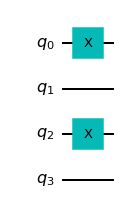

In [11]:
hydrogen_initial_state = HartreeFock(num_hydrogen_spin_orbitals,
                                     num_hydrogen_electrons_spin_up_spin_down,
                                     map_fermions_to_qubits)
hydrogen_initial_state.draw("mpl")

*最後に、Qiskitには、上記の情報を用いてHF近似にヒントを得たパラメータ化された試行状態を作成するクラス(Unitary Coupled Cluster Single and Double excitations, `UCCSD`)が用意されており、基底状態を見つけるために反復的に調整することができます：*

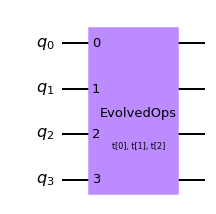

In [12]:
hydrogen_chemistry_inspired_trial = UCCSD(map_fermions_to_qubits,
                                          num_hydrogen_electrons_spin_up_spin_down,
                                          num_hydrogen_spin_orbitals,
                                          initial_state=hydrogen_initial_state)
hydrogen_chemistry_inspired_trial.draw("mpl")

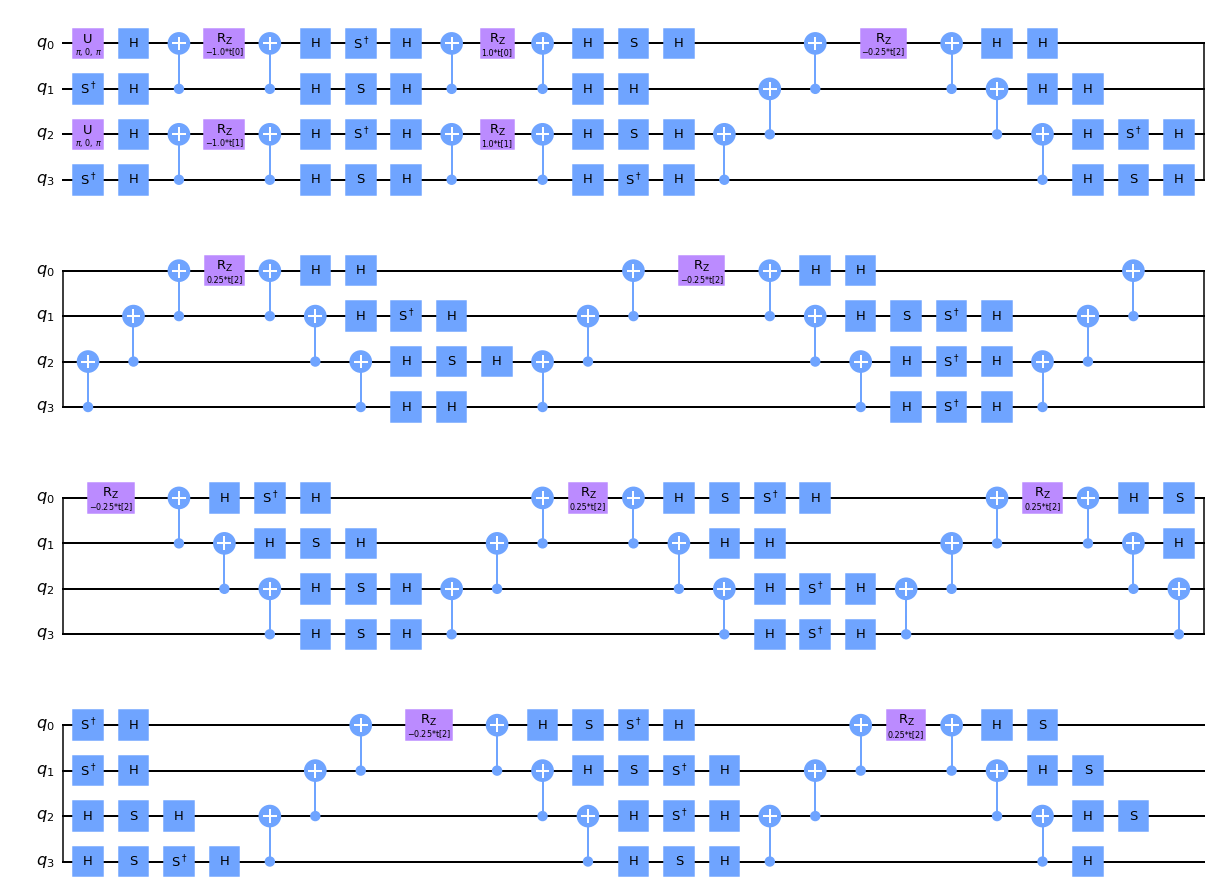

In [13]:
hydrogen_chemistry_inspired_trial.decompose().decompose().decompose().draw("mpl")

#### *ハードウェアにヒントを得た試行状態*

上記の*化学にヒントを得た*試行状態の問題点は、非常にDepthが深く、現在の量子コンピューターの利用可能なDepthをすぐに使い切ってしまうことです。そこで、別の案として、化学の知識を捨てて、現在のハードウェアで簡単に準備でき、パラメトリックに "変化" させることができる試行状態で、任意の状態を表現することを考えます。任意の状態を表現するための量子演算には、「混合」（*条件付きサブ空間の回転*）と「回転」（*無条件回転*）の2種類があります。これらの操作とそのサブオプションがどのように機能するかについての詳細な知識は、特に必要ありません。なぜなら、どの設定が最良の結果をもたらすかは、すぐにはわからないからです。

##### 混合 (エンタングルメントマップとも呼ばれる)

利用可能な様々な混合のセットがあり、試すことができます。 *`entanglement`* （何を混ぜるか）と *`entanglement_blocks`* （どのように混ぜるか）の2つの引数で指定します：

- 利用可能な *`entanglement`* の値: `'linear'`, `'full'`, `'circular'`, `'sca'`

- 利用可能な *`entanglement_blocks`* の値: `'cz'`, `'cx'`

ここでは、それぞれ最初の選択肢(`'linear'`と`'cz'`)を使うだけで十分です。

##### 回転

*パラメタライズ* された様々な回転が用意されています。回転は1つの引数 *`rotation_blocks`* で指定され、以下のような組み合わせのリストになっています:

- 利用可能な *`rotation_blocks`*: `'ry'`, `'rx'`,`'rz'`,`'h'`, ...

通常、試行状態にパラメーターが導入されるのはここだけです。回転ごとに1つのパラメーターが導入され，関連する軸の周りの回転角度に対応します(なお、 `'h'` はパラメータを持たないため、単独で選択することはできません)。

ここでも、我々の目的のためには、リストの中の最初のもの（`'ry'`）を選べば大丈夫です。

*Qiskitには、局所的な操作のみでランダムな試行状態を作成する`TwoLocal`というクラスがあります。局所的な操作の **rounds** （繰り返し）数は、引数 `reps` で指定します：*

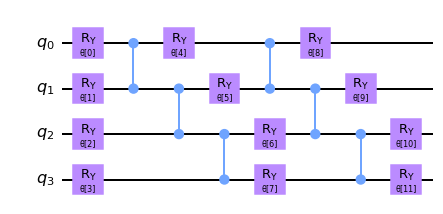

In [14]:
hardware_inspired_trial = TwoLocal(4, rotation_blocks = ['ry'], entanglement_blocks = 'cz',
                                   entanglement='linear', reps=2)
hardware_inspired_trial.decompose().draw("mpl")

(この試行状態は分子に依存しません)。

*便宜上、2つのアプローチのどちらを選択するか変数に代入しておきましょう：*

In [15]:
hydrogen_trial_state = hydrogen_chemistry_inspired_trial
# または
# hydrogen_trial_state = hardware_inspired_trial

<h3><a id='step_3b'>Step 3b: VQEのQ（量子の動作環境）</a></h3>

VQEは量子コンピューター上で動作するため、このステージに関する情報が必要となります。テストのために、ノイズのないシミュレーションやノイズのあるシミュレーションを行うことができます。最終的には、（ノイズが多いとはいえ）実際の量子ハードウェアでVQEを動作させ、そう遠くない将来に、古典では達成できない結果を得たいと考えています。

#### ノイズフリーシミュレーション

*ノイズのないシミュレーションを行うには、以下の手順に従います。*

In [16]:
noise_free_quantum_environment = QuantumInstance(Aer.get_backend('statevector_simulator'))

<h3><a id='step_3c'>Step 3c: VQEの初期化</a></h3>

Qiskit Natureは、VQEアルゴリズムを実装したVQEというクラスを提供しています。*VQEは（分子やハミルトニアンを参照しない）一般的な方法で初期化され、上述の2つの情報（試行状態と量子の動作環境）を必要とします。*

In [17]:
hydrogen_vqe_solver = VQE(ansatz=hydrogen_trial_state, quantum_instance=noise_free_quantum_environment)

(なお、vqe solver は、試行状態が hydrogen_chemistry_inspired_trial である場合にのみ、水素に合わせて調整されます)。

<h2><a id='step_4'>Step 4: 基底状態を解く</a></h4>

**Qiskit Natureは分子の基底状態を計算するためにGroundStateEigensolverというクラスを用意しています。**

このクラスはまず、どの分子にも依存しない情報で初期化されます。その後、その一般的な設定を使用して、特定の分子に適用します。

GroundStateEigensolver オブジェクトを初期化するためには，上述の2つの一般的なアルゴリズムのサブ・コンポーネント，すなわち，マッピング・メソッド（Step 2b）とソルビング・メソッド（Step 3）を提供する必要があります。テストのために，VQEソルバーに代わるものとして，古典的なソルバーがあります（以下のnumpy_solverを参照）。

In [18]:
hydrogen_ground_state = GroundStateEigensolver(map_fermions_to_qubits, hydrogen_vqe_solver)

これでようやく、分子の基底状態のエネルギーを求める準備が整いました。

分子（Step 1）をエンコードしたフェルミ演算子のハミルトニアン（Step 2a）にGroundStateEigensolver を適用します。すると、すでに指定されているマッパーとVQEソルバーが自動的に適用され、基底状態（近似）が生成されます。

In [19]:
hydrogen_ground_state_info = hydrogen_ground_state.solve(hydrogen_fermionic_hamiltonian)

print(hydrogen_ground_state_info)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030145
  - computed part:      -1.857275030145
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035696
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.38894874]
    - computed part:      [0.0  0.0  1.38894874]
  > Dipole moment (a.u.): [0.0  0.0  -0.00000004]  Total: 0.00000004
                 (debye): [0.0  0.0  -0.0000001]  Total: 0.0000001
 


ご覧のように、電子分布の基底状態のエネルギーを計算しました：-1.85 Hartree

原子核の配置から、便利なことに反発エネルギー（Nuclear repulsion energy）も与えられています（古典計算から求められます）。

最後に、分子全体の基底状態を考え、最小化したいのは全基底状態エネルギーです。

つまり、次のステップは、原子核を移動させて **全基底状態エネルギー** を再計算し、安定した原子核の位置を探すことになります。

最後に、量子力学的に計算されたエネルギーと、それと同等の精度（ただし時間はかかる）で古典計算されたエネルギーを比較してみよう。

In [20]:
# Step 3bの別の方法
numpy_solver = NumPyMinimumEigensolver()

# Step 4の別の方法
ground_state_classical = GroundStateEigensolver(map_fermions_to_qubits, numpy_solver)
hydrogen_ground_state_info_classical = ground_state_classical.solve(hydrogen_fermionic_hamiltonian)

hydrogen_energy_classical = hydrogen_ground_state_info.computed_energies[0]
print("基底状態の電子エネルギー（古典計算による）: ", hydrogen_energy_classical, "Hartree")

基底状態の電子エネルギー（古典計算による）:  -1.8572750301448666 Hartree


小数点以下の何桁にも及ぶ一致は、この特定のハミルトニアンに対して、VQEプロセスが正確に最低固有値を見つけていることを示しています（興味深いことに、Ansatz/試行状態はヒルベルト空間全体に渡っているためか、基底状態の捕捉に失敗していません）。しかし、自然界や非常に精度の高い $H_2$ の古典シミュレーションと比較すると、エネルギーは小数点以下2桁までしか一致しないことがわかります。例えば、全エネルギーは、VQE：-1.137 Hartree 対 高精度古典シミュレーション：-1.166 Hartree であり、小数点以下2桁までしか一致しません。この理由は、上記の処理では、原子核の配置やハートリーフォック展開に伴う多くの近似など、モデリングエラーの原因があるためです。$H_2$ については、これらに対処することができますが、一般的には、これらの原因のうち、より厄介なものを完全に処理することはできません。なぜなら、完全な基底状態を見つけることは、QMA-complete、すなわちNP-completeの量子版である（特定のハミルトニアンについては「解けない」）からです。しかし、自然そのものがこの完全な基底状態を見つけるとは期待されていないので、ある量子計算の解法が自然の解法にどれだけ近似しているかを調べるには、今後の実験が必要となります。

<div align=center class="alert alert-block alert-success">
<h1>例題終了</h1>
</div>


***


<div align=center class="alert alert-block alert-success">
    <h1><a id='challenge'>HIVチャレンジ</a></h1>
</div>


例題が終了したので、次に、関連する質問に答えながらStep 1～4を洗練させるタスクとしてチャレンジを進めていきます。

<h2><a id='refine_step_1'>1. Step 1の改良: 分子を変化させる</a></h2>

Step 1 では、分子の定義を行いました。今回の課題では、まず、プロテアーゼ分子（*ハサミ*）のトイモデルと、近づいてきた抗レトロウイルス（*ブロッカー*）のトイモデルを対応させて、*マクロ分子*を形成する新しい分子を定義する必要があります。次に、Qiskitに接近距離を変化させるように指示する必要があります。それでは、おなじみの水素分子を使って、その方法を学んでみましょう。

*ここでは、私たちが興味を持っている分子の変化（molecular variatio）の種類（すなわち、接近距離を絶対的なステップで変化させること）を指定する方法を紹介します*：

In [21]:
molecular_variation = Molecule.absolute_stretching

# 他の種類のmolecular variation:
#molecular_variation = Molecule.relative_stretching
#molecular_variation = Molecule.absolute_bending
#molecular_variation = Molecule.relative_bending

*ここでは、どの原子に変化が適用されるかを指定する方法を説明します。数字はジオメトリーの定義リストの中の原子のインデックスを参照しています。指定されたatom_pairのindex 0の原子が、左にあるindex 1の原子に近づきます。*

In [22]:
specific_molecular_variation = apply_variation_to_atom_pair(molecular_variation, atom_pair=(1, 0))

*例題でご紹介した分子の定義を変更する方法を紹介します。*


In [23]:
hydrogen_molecule_stretchable = Molecule(geometry=
                                 [['H', [0., 0., 0.]],
                                  ['H', [0., 0., 0.735]]],
                                  charge=0, multiplicity=1,
                                  degrees_of_freedom=[specific_molecular_variation])


変化が起きているかどうかをテストしたい場合は、手動で任意の変化量を指定し（Qiskitはこれを*perturbation*（摂動）と呼びます）、新しいジオメトリーがどうなるかを確認することができます：

In [24]:
hydrogen_molecule_stretchable.perturbations = [0.1]

(上記が指定されていない場合、摂動はゼロとなり、デフォルトでは元のジオメトリになります。)

In [25]:
hydrogen_molecule_stretchable.geometry

[['H', [0.0, 0.0, 0.0]], ('H', [0.0, 0.0, 0.835])]

ジオメトリーのリストの2番目の原子（atom_pairの最初に指定されているindex 1のもの）だけが、指定した量だけ他の原子に近づいていることに注目してください。異なる接近距離をスキャンする際には、Qiskitが非常に便利に自動化してくれます。

## プロテアーゼ＋抗レトロウイルス薬のマクロ分子の特定

### プロテアーゼ

実際のプロテアーゼ分子は、約100個のアミノ酸からなる2本のポリペプチド鎖で構成されており（2本の鎖は折りたたまれています）、隣り合うアミノ酸同士はいわゆる*ペプチド結合*で結ばれています。

<img src="./resources/peptide_bond_wikipedia.png" title="Amino Acid bonding"/>

私たちのプロテアーゼ分子のトイモデルは、このペプチド結合からヒントを得ることにしました。ペプチド結合は、多数のアミノ酸を結合しタンパク質を作る基本的な構造です。ペプチド結合は、一般的なタンパク質の折り畳みや、HIVプロテアーゼの切断能力など、タンパク質の化学的性質を決定する最も重要な要素の1つです。

計算を簡単にするために、分子のO=C-Nの部分に注目してみましょう。分子をできるだけ現実的なものにするために、十分な量の水素原子(H)を残し、また追加します（実際、HCONH$_2$（ホルムアミド）は安定した分子で、イオン性の溶媒でもあるので、イオン結合を「切る」ことができます。)

O=C-Nをプロテアーゼ分子のトイモデルにすること、非常に単純化されてはいますが、それでも生物学的に動機付けされています。
これがそのプロテアーゼのトイモデルです：

<img width=50% src="./resources/protease.png"/>

```
"O":  (1.1280, 0.2091, 0.0000)
"N": (-1.1878, 0.1791, 0.0000)
"C": (0.0598, -0.3882, 0.0000)
"H": (-1.3085, 1.1864, 0.0001)
"H": (-2.0305, -0.3861, -0.0001)
"H": (-0.0014, -1.4883, -0.0001)
```

この分子をハサミに見立てて、HIVウイルスのコピーを作る過程で、HIVのマスタータンパク質（Gag-Pol高タンパク質）を切ることができると想像してみてください：

<img width=30% src="./resources/carpet_scissors_wikipedia_cropped.png"/>

### 抗レトロウイルス

抗レトロウイルス剤とは、プロテアーゼと結合して、その**切断機構を阻害する**分子のことです。今回のチャレンジでは、1個の炭素原子(C)を抗レトロウイルス分子の代用とします。

<img width=10% src="./resources/arv.png"/>

### マクロ分子
2つの分子は私たちの頭の中では別々になっていますが、接近すると、外側の電子がすべての原子の周りに分子軌道を形成して、1つのマクロ分子になります。

水素の例題で説明したように、量子的な電子分布は原子の位置を固定して計算されるので、原子を個別に配置する必要があります。1つ目と2つ目の課題では、プロテアーゼの座標を固定し、抗レトロウイルスの位置だけを直線に沿って変化させます。

その際、任意の点を通り、窒素原子(N)に近づくアプローチの線を選びます。この「ブロック」と呼ばれるアプローチは、ハサミが切るのを邪魔しようとするものです。それが「刺さった」となれば成功で、HIVの複製活動を妨害することに成功したことになります。

<h2><a id='exercise_3a'>Exercise 3a: ブロッキングアプローチによるマクロ分子の分子定義</a></h2>

抗レトロウイルス剤が「刃」の間にある窒素原子（N）に接近する様子を表現するために、分子定義と分子変化を構築します：
<img width=50% src="./resources/arv_approaches_protease.png"/>
 ```
 "C": (-0.1805, 1.3955, 0.0000)
 ```

## ここにコードを書いてください：

下のセルにあなたの分子を作ってください。分子の名前は必ず`macromolecule`としてください。

In [ ]:
## ここにコードを書いてください

macromolecule = None

##

以下のセルを実行して、答えを確認します。

In [ ]:
from qc_grader import grade_ex3a

grade_ex3a(molecule=macromolecule)

<h2><a id='refine_step_2'>2. Step 2の改良：量子ワークロードの削減</a></h2>

Step 2では、量子ビット・ハミルトニアンを構築しました。上記のマクロ分子にStep 2以降を適用しようとすると、基底状態計算シミュレーションは失敗します。なぜかというと、電荷を0に指定しましたが、Qiskitは30(=2\*6(2個の炭素)+7(窒素)+8(酸素)+3\*1(3つの水素))個の電子で動作しなければならないことを知っているからです。これは、第二量子化を行うと、60個のスピン軌道に変換されるので、60量子ビットが必要となります。60量子ビットは、私たちが古典シミュレーションできる範囲を超えており、60量子ビット以上のIBM量子システムもありますが、私たちは使えません。したがって、このチャレンジの目的のために、量子ビットの数を減らす必要があります。幸いなことに、この量子ビット数の削減は化学的な観点からも理由があります。正確な化学的結果を得るためには、内殻電子に対して古典的なハートリーフォック近似で十分な場合があります。さらに幸いなことに、Qiskitはつい最近拡張され、特定の電子を量子計算で処理し、残りの電子を古典的に近似するようにユーザーがシームレスに指定できるようになりました。今後、さらに多くの量子ビットが使えるようになったとしても、近未来の量子コンピューターが通常では手の届かない非常に大きな分子に取り組む際に、この機能は非常に有用であることがわかるでしょう。

*そこで次に、Qiskitに指示して、ある数の電子に量子計算処理をさせる方法を紹介します：*

In [ ]:
macro_molecular_orbital_maker = PySCFDriver(molecule=macromolecule, unit=UnitsType.ANGSTROM, basis='sto3g')
split_into_classical_and_quantum = ActiveSpaceTransformer(num_electrons=2, num_molecular_orbitals=2)
macro_fermionic_hamiltonian = ElectronicStructureProblem(macro_molecular_orbital_maker, [split_into_classical_and_quantum])

上記のように、Qiskitには**ActiveSpaceTransformer**というクラスがあり、2つの引数を受け取ります。1つ目は、量子計算処理を受けるべき電子の数です（一番外側の電子から順に選んでいきます）。2つ目は、それらの電子が自由に動き回れるようにするための軌道の数（いわゆるフェルミ準位）です。必要な量子ビット数を決めるのは、この2つ目の数です。（NとCの結合なのでそれぞれ1個ずつ合計2個の電子をアクティブな電子として扱い、それ以外の内殻電子は非アクティブな電子とする。）

<h2><a id='exercise_3b'>Exercise 3b: 古典-量子処理に関する概念的な質問（多肢選択式)</a></h2>

Q1: 高分子の外側の電子を先に量子処理する方がヒューリスティックな意味を持つのはなぜですか？

```
A: 外側の電子の方が結合エネルギーが高く、基底状態のエネルギーの揺れが大きいため、量子処理が必要になります。
B: 外側の電子は軌道が広がっているので、量子干渉が多くなるからです。
C: 内殻電子は通常、より素直に軌道を占有します。なぜなら、ほとんどの場合、単一の原子核の周りを回るので、外殻電子と相互作用したりエンタングルしたりしてもエネルギーがあまり下がらないからです。

```

Q2: 量子で扱う電子の数が一定の場合、それらの電子が周回する（アクセスできる）軌道の数を増やすと、計算される基底状態のエネルギーは、上からも下からも漸近的なエネルギーに近づくのでしょうか？
```
A: 漸近エネルギーは上から近づいてきます。なぜなら、電子がアクセスできる軌道の数を増やせば増やすほど、基底状態は低くなる可能性があるからです。
B: 漸近エネルギーは下から近づきます。なぜなら、可能な軌道を増やせば増やすほど、シミュレーションがより正確になり、以前は除外されていたエネルギーが追加されるからです。
C: 漸近エネルギーは下から近づきます。なぜなら、電子がアクセスできる可能性のある軌道を増やせば増やすほど、基底状態が低くなる可能性があるからです。
D: 漸近エネルギーは上から近づきます。なぜなら、可能な軌道を増やせば増やすほど、シミュレーションがより正確になり、以前は省かれていたエネルギーが追加されるからです。
```

**これらの多肢選択問題に対する解答を、以下のコードセルでアンコメントしてください。答えを確認するためにセルを実行してください。**

In [ ]:
from qc_grader import grade_ex3b

## Q1
# answer_for_ex3b_q1 = 'A'
# answer_for_ex3b_q1 = 'B'
# answer_for_ex3b_q1 = 'C'
##
answer_for_ex3b_q1 = ''
## Q2
# answer_for_ex3b_q2 = 'A'
# answer_for_ex3b_q2 = 'B'
# answer_for_ex3b_q2 = 'C'
# answer_for_ex3b_q2 = 'D'
##
answer_for_ex3b_q2 = ''

grade_ex3b(answer_for_ex3b_q1, answer_for_ex3b_q2)

<h2><a id='refine_step_4'>3. Step 4の改良：エネルギー曲面</a></h2>

Step 4では、与えられた分子に対して一度だけ ground_state solver を実行しましたが、上で紹介した仕様を使ってQiskitに分子の形状を変化させるように指示する方法はまだ説明していません。冒頭で説明したように、原子核の位置を変えて全エネルギーレベルを比較することで、最もエネルギーが低い原子核の配置を見つける方法です。最も低いエネルギーが「無限大」で**ない**場合、これはエネルギーが最小となる分子の「安定した」結合状態に相当します。このように、エネルギーを原子間距離の関数として求めることは、非常に重要な研究対象です。この関数は **Born-Oppenheimer Potential Energy Surface (BOPES)** と呼ばれています。Qiskit は、形状を変化させ、ground_state solver を繰り返し呼び出すこのプロセスを管理する便利な python クラスを提供します。: **BOPESSampler** です。

水素分子のBOPESSamplerをデモしてみましょう。

*水素分子の例題で再実行する必要があるのは、Steps 1 と2aだけです：*

In [26]:
hydrogen_stretchable_molecular_orbital_maker = PySCFDriver(molecule=hydrogen_molecule_stretchable, unit=UnitsType.ANGSTROM, basis='sto3g')
hydrogen_stretchable_fermionic_hamiltonian = ElectronicStructureProblem(hydrogen_stretchable_molecular_orbital_maker)

*次に、サンプラーの呼び出し方です。：*

In [27]:
energy_surface = BOPESSampler(gss=hydrogen_ground_state, bootstrap=False) # 試行が同じなので、Step4で設定したソルバーで十分です
perturbation_steps = np.linspace(-0.5, 2, 25) # 0.5～2までの25点を等間隔に配置する

energy_surface_result = energy_surface.sample(hydrogen_stretchable_fermionic_hamiltonian, perturbation_steps)

<ipython-input-27-54ba2d5330fb>:4: DeprecationWarning: The qiskit_nature.drivers.pyscfd.pyscfdriver.PySCFDriver class is deprecated as of version 0.2.0 and will be removed no sooner than 3 months after the release. Instead use the ElectronicStructureMoleculeDriver or VibrationalStructureMoleculeDriver class from qiskit_nature.drivers.second_quantization.
  energy_surface_result = energy_surface.sample(hydrogen_stretchable_fermionic_hamiltonian, perturbation_steps)


*次に、有名なエネルギー曲面のプロット作成方法です。：*

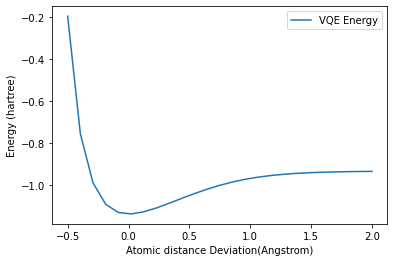

In [28]:
def plot_energy_landscape(energy_surface_result):
    if len(energy_surface_result.points) > 1:
        plt.plot(energy_surface_result.points, energy_surface_result.energies, label="VQE Energy")
        plt.xlabel('Atomic distance Deviation(Angstrom)')
        plt.ylabel('Energy (hartree)')
        plt.legend()
        plt.show()
    else:
        print("Total Energy is: ", energy_surface_result.energies[0], "hartree")
        print("(No need to plot, only one configuration calculated.)")
    
plot_energy_landscape(energy_surface_result)

直感的には、エネルギー地形を、山と谷、そしてボールが転がる台地の隣にあると考えるとよいでしょう（ボールのx座標は、2つの水素原子の間隔に対応します）。ボールが台地を転がる速度が速すぎなければ（右から左へ）、ボールは谷に落ち着くかもしれません。傾きが正（2つの水素原子の間に引力があることを表す）なので、ボールはゆっくりと台地を転がり落ちます。ボールが谷である最小点を通り越すと、山の急な負の傾きの斜面にぶつかり、すぐに転がり戻ってしまいます（水素原子は互いに反発します）。

ここで、最小値がゼロであることに注目してください。これは、水素分子の原子核の位置を、既知の基底状態の位置に定義したからです。

ちなみに、hardware_inspired_trialを使えば、同じようなプロットができたと思いますが、Anzatzが異なる結合長で電子基底状態を均等に捕らえることができないため、凸凹ができたと思われます。

<h2><a id='exercise_3c'>Exercise 3c: エネルギー曲面　結合するかしないか？</a></h2>

100万ドルの質問です：私たちの抗レトロウイルス剤のトイモデルはプロテアーゼと結合し、反応をブロックするのでしょうか？

 - 30点で-0.5から5までの最小値を探します。
 - 2つの軌道を回る2つの電子を量子コンピューターで扱います。

Q1. 
抗レトロウイルス剤がプロテアーゼに接近したときのエネルギー・ランドスケープを作成してください。

Q2. 
有限の距離に明確な最小値はありますか？結合は起こりますか？

```
A. はい。0で明確な最小値がありますので、結合は起こります。
B. はい。無限大に明確な最小値があるので、結合は無限大でのみ起こります。
C. いいえ。どのような分離でも明確な最小値はなく、分離がないので結合が起こります。
D. いいえ。どのような分離にも明確な最小値はないので、結合はありません。
```

(答えを先取りしないでください。さらに、他のアプローチや他の設定でも答えが変わる可能性がありますので、要求された設定に従ってください)

*次の関数を自由に使ってください。この関数は、水素分子で行った例題のStepとそのうちのStep 2と4の改良版です。この関数には、分子（Step 1の改良タイプ）、その他の改良点、VQEとnumpy solverのどちらを使用するかのブール値が渡されます。*

In [ ]:
def construct_hamiltonian_solve_ground_state(
    molecule,
    num_electrons=2,
    num_molecular_orbitals=2,
    chemistry_inspired=True,
    hardware_inspired_trial=None,
    vqe=True,
    perturbation_steps=np.linspace(-1, 1, 3),
):
    """Creates fermionic Hamiltonion and solves for the energy surface.
    フェルミ演算子ハミルトニアンを作り、エネルギー面を作ります

    Args:
        molecule (Union[qiskit_nature.drivers.molecule.Molecule, NoneType]): シミュレートする分子
        num_electrons (int, optional): `ActiveSpaceTransformer`の電子の数。デフォルトは2。
        num_molecular_orbitals (int, optional): `ActiveSpaceTransformer`の電子軌道の数。デフォルトは2。
        chemistry_inspired (bool, optional): 化学にヒントを得た試行状態を使うかどうか。使う場合は、`hardware_inspired_trial`は`None`でなければならない。デフォルトはTrue。
        hardware_inspired_trial (QuantumCircuit, optional): ハードウェアにヒントを得た試行状態を使うかどうか。使う場合は、`chemistry_inspired`はFalse。デフォルトはNone。
        vqe (bool, optional): VQEをエネルギー面の計算に使うかどうか。Falseの場合は、`NumPyMinimumEigensolver。デフォルトはTrue。
        perturbation_steps (Union(list,numpy.ndarray), optional): 摂動のステップ。評価する点。この場合は距離（単位はÅ）。 デフォルトはnp.linspace(-1, 1, 3)。

    Raises:
        RuntimeError: `chemistry_inspired`と`hardware_inspired_trial`は同時には使えません。`chemistry_inspired`がFalseかまたは、`hardware_inspired_trial`を`None`にしてください。

    Returns:
        qiskit_nature.results.BOPESSamplerResult: BOPESSamplerResultオブジェクトとしてのエネルギー面。
    """
    # `chemistry_inspired`とhardware_inspired_trial`がコンフリクトしていないことを確認
    if chemistry_inspired and hardware_inspired_trial is not None:
        raise RuntimeError(
            (
                "chemistry_inspired and hardware_inspired_trial"
                " cannot both be set. Either chemistry_inspired"
                " must be False or hardware_inspired_trial must be none."
            )
        )

    # Step 1 の改良版が渡されました

    # Step 2a
    molecular_orbital_maker = PySCFDriver(
        molecule=molecule, unit=UnitsType.ANGSTROM, basis="sto3g"
    )

    # Step 2a の改良版
    split_into_classical_and_quantum = ActiveSpaceTransformer(
        num_electrons=num_electrons, num_molecular_orbitals=num_molecular_orbitals
    )

    fermionic_hamiltonian = ElectronicStructureProblem(
        molecular_orbital_maker, [split_into_classical_and_quantum]
    )
    fermionic_hamiltonian.second_q_ops()

    # Step 2b
    map_fermions_to_qubits = QubitConverter(JordanWignerMapper())

    # Step 3a
    if chemistry_inspired:
        molecule_info = fermionic_hamiltonian.grouped_property_transformed
        particle_number = molecule_info.get_property(ParticleNumber)
        num_spin_orbitals = particle_number.num_spin_orbitals
        num_electrons_spin_up_spin_down = (
            particle_number.num_alpha,
            particle_number.num_beta,
        )
        initial_state = HartreeFock(
            num_spin_orbitals, num_electrons_spin_up_spin_down, map_fermions_to_qubits
        )

        chemistry_inspired_trial = UCCSD(
            map_fermions_to_qubits,
            num_electrons_spin_up_spin_down,
            num_spin_orbitals,
            initial_state=initial_state,
        )

        trial_state = chemistry_inspired_trial
    else:
        if hardware_inspired_trial is None:
            hardware_inspired_trial = TwoLocal(
                rotation_blocks=["ry"],
                entanglement_blocks="cz",
                entanglement="linear",
                reps=2,
            )

        trial_state = hardware_inspired_trial

    # Step 3b 
    if vqe:
        noise_free_quantum_environment = QuantumInstance(Aer.get_backend('statevector_simulator'))
        solver = VQE(ansatz=trial_state, quantum_instance=noise_free_quantum_environment)
    else:
        solver = NumPyMinimumEigensolver()

    # Step 4 
    ground_state = GroundStateEigensolver(map_fermions_to_qubits, solver)

    # Step 4 の改良版
    energy_surface = BOPESSampler(gss=ground_state, bootstrap=False)
    energy_surface_result = energy_surface.sample(
        fermionic_hamiltonian, perturbation_steps
    )

    return energy_surface_result

### あなたの答え


以下のコードセルは、`construct_hamiltonian_solve_ground_state` を呼び出し、その結果をプロットするためのスケルトンを示しています。自分の結果に自信が持てたら、次のコードセルに投稿してください。

**注意： `construct_hamiltonian_solve_ground_state` の実行には時間がかかります（約2分）。すぐに結果が返ってこなくても心配しないでください。**


In [ ]:
# Q1

# Calculate the energies
#q1_energy_surface_result = construct_hamiltonian_solve_ground_state(
#    molecule=None,
#    num_electrons=None,
#    num_molecular_orbitals=None,
#    chemistry_inspired=None,
#    vqe=None,
#    perturbation_steps=None,
#)

In [ ]:
# Plot the energies to visualize the results
# plot_energy_landscape(energy_surface_result)

In [ ]:
## Q2
# answer_for_ex3c_q2 = 'A'
# answer_for_ex3c_q2 = 'B'
# answer_for_ex3c_q2 = 'C'
# answer_for_ex3c_q2 = 'D'
answer_for_ex3c_q2 = ''

得られた結果に満足したら、次のセルで `construct_hamiltonian_solve_ground_state` のエネルギーとパラメータを送信します。`energy_surface`を除くすべてのパラメータの値を、`construct_hamiltonian_solve_ground_state`の呼び出しで使用したものと同じ値に変更します。

In [ ]:
from qc_grader import grade_ex3c

grade_ex3c(
    energy_surface=None, #q1_energy_surface_result.energies,
    molecule=None,
    num_electrons=None,
    num_molecular_orbitals=None,
    chemistry_inspired=None,
    hardware_inspired_trial=None,
    vqe=None,
    perturbation_steps=None,
    q2_multiple_choice=answer_for_ex3c_q2
)

<h2><a id='refine_step_3a'>4. Step 3aの改良</a></h2>

最後の改良は、ブラックボックスでの調整がどのように結果を改善するかのレッスンです。

Step 3aでは，hardware_inspired_trialを現在の実際のハードウェア上で実行するように設計しました。水素分子での例題でのこの行を思い出してください：

In [ ]:
hardware_inspired_trial = TwoLocal(rotation_blocks = ['ry'], entanglement_blocks = 'cz',
                                   entanglement='linear', reps=2)

ここでは、`reps` (repetition) パラメーターについて説明します。このパラメーターは、トライアルの状態で、混合と回転を何ラウンド繰り返すかを制御します。具体的には、最初に回転のラウンドがあり、その後、混合（パラメーターを含まないことが多い）と回転のラウンドが繰り返されます。パラメーターがないゲートもあります（例：`h`, `cz`）。回転のラウンドごとに、古典オプティマイザーが基底状態を探索する際に調整するパラメーターのセットが追加されます。

簡単な水素分子をもう一度見て、化学にヒントを得た試行状態、numpy solver、摂動なしを使って、「理想的な」最低エネルギーの電子エネルギーを計算してみましょう：

In [ ]:
true_total_energy = construct_hamiltonian_solve_ground_state(
                                molecule=hydrogen_molecule_stretchable,  # Step 1
                                num_electrons=2,                         # Step 2a
                                num_molecular_orbitals=2,                # Step 2a
                                chemistry_inspired=True,                 # Step 3a
                                vqe=False,                               # Step 3b
                                perturbation_steps = [0])                # Step 4
plot_energy_landscape(true_total_energy)

残りの実験では、上記の値を真の値として参照します。

*次に，`chemistry_inspired=False`, `vqe=True` を選択し，1ラウンドのハードウェアにヒントを得た試行状態を行います*：

In [ ]:
hardware_inspired_trial = TwoLocal(rotation_blocks = ['ry'], entanglement_blocks = 'cz',
                                   entanglement='linear', reps=1)

quantum_calc_total_energy = construct_hamiltonian_solve_ground_state(
                                molecule=hydrogen_molecule_stretchable,           # Step 1
                                num_electrons=2,                                  # Step 2a
                                num_molecular_orbitals=2,                         # Step 2a
                                chemistry_inspired=False,                         # Step 3a
                                hardware_inspired_trial=hardware_inspired_trial,  # Step 3a
                                vqe=True,                                         # Step 3b
                                perturbation_steps = [0])                         # Step 4
plot_energy_landscape(quantum_calc_total_energy)

*差は小さく、正であることがわかります：*


In [ ]:
quantum_calc_total_energy.energies[0] - true_total_energy.energies[0]

*試行状態のパラメーターの数を見てみましょう：*

In [ ]:
total_number_of_parameters = len(hardware_inspired_trial._ordered_parameters)
print("Total number of adjustable parameters: ", total_number_of_parameters)

<h2><a id='exercise_3d'>Exercise 3d: 反復回数が多い場合の効果</a></h2>

Q1: 
反復`reps`数を1（すでに実行しています）と2にして、誤差を比較してみてください。`reps`数を増やすと誤差増えますか？減りますか？それとも変わらないですか？

以下の点に注意してください：

 - VQEは統計的なアルゴリズムなので、何度か実行してからパターンを観察してみてください。
 - 2を超えると、パターンが継続しないかもしれません。
 - `reps` は `TwoLocal` で定義されています。

Q2: 
`reps` が 1 と 2 の場合のパラメーターの総数を調べてみましょう。1回の回転で何個のパラメーターが導入されますか？

## 答えをここに書いてください:

**下のコードセルの最初の多肢選択問題の答えのコメントを外して，Q2の答えを追加してください．セルを実行して、答えを確認してください。**

In [ ]:
from qc_grader import grade_ex3d

## Q1
# answer_for_ex3d_q1 = 'decreases'
# answer_for_ex3d_q1 = 'increases'
# answer_for_ex3d_q1 = 'stays the same'
##
answer_for_ex3d_q1 = ''

## Q2
answer_for_ex3d_q2 = 0
##

grade_ex3d(answer_for_ex3d_q1, answer_for_ex3d_q2)

<h2><a id='exercise_3e'>Exercise 3e: 自由形式：マクロ分子のエネルギー誤差を最小化するための最適なhardware_inspired_trialを見つけよう</a></h2>

再びマクロ分子に目を向けてみましょう。`chemistry_inspired=False`, `vqe=True`, `perturbation_steps = [0]`、最大8量子ビット、例題のオプションを任意に組み合わせた独自の`hardware_inspired_trial`を使用して、最も低いエネルギーを見つけてください。この課題の解答には、`construct_hamiltonian_solve_ground_state` に渡されたすべてのパラメーターと、それが返す結果オブジェクトが含まれます。この課題は、計算したエネルギー $E_{computed}$ がマクロ分子の「真の」最小エネルギー $E_{true}$にどれだけ近いかで得点化するものです。このスコアは以下のように計算され、最も近い整数に丸められます。

$$\text{score} = -10 \times \log_{10}{\left(\left\lvert{\frac{E_{true} - E_{computed}}{E_{true}}}\right\rvert\right)}$$

計算したエネルギーの誤差を小さくすることで、スコアが上がります。例えば、真のエネルギーが-42.141で、-40.0を計算した場合、スコアは13となります。次のコードセルを使って，さまざまな `hardware_inspired_trial` を試してみてください。

In [ ]:
# 以下の変数を変えてください
num_electrons = 
num_molecular_orbitals = 
hardware_inspired_trial = 
#

computed_macromolecule_energy_result = construct_hamiltonian_solve_ground_state(
    molecule=macromolecule,
    num_electrons=num_electrons,
    num_molecular_orbitals=num_molecular_orbitals,
    chemistry_inspired=False,
    hardware_inspired_trial=hardware_inspired_trial,
    vqe=True,
    perturbation_steps=[0],
)

以下のコードセルを実行して、計算されたエネルギーを採点します。複数回の実行が可能です。

In [ ]:
from qc_grader import grade_ex3e

grade_ex3e(
    energy_surface_result=computed_macromolecule_energy_result,
    molecule=macromolecule,
    num_electrons=num_electrons,
    num_molecular_orbitals=num_molecular_orbitals,
    chemistry_inspired=False,
    hardware_inspired_trial=hardware_inspired_trial,
    vqe=True,
    perturbation_steps=[0],
)

----------------

#### <a id='qresource'>Quantum Chemistry Resources</a>
*Videos*
- *Quantum Chemistry I: Obtaining the Qubit Hamiltonian* 
    - https://www.youtube.com/watch?v=2XEjrwWhr88
- *Quantum Chemistry II: Finding the Ground States* 
    - https://www.youtube.com/watch?v=_UW6puuGa5E 
    - https://www.youtube.com/watch?v=o4BAOKbcd3o
*Tutorials*
- https://qiskit.org/documentation/nature/tutorials/01_electronic_structure.html 
- https://qiskit.org/documentation/nature/tutorials/03_ground_state_solvers.html 
- https://qiskit.org/documentation/nature/tutorials/05_Sampling_potential_energy_surfaces.html
*Code References*
- UCCSD : https://qiskit.org/documentation/stubs/qiskit.chemistry.components.variational_forms.UCCSD.html
- ActiveSpaceTransformer: https://qiskit.org/documentation/nature/stubs/qiskit_nature.transformers.second_quantization.electronic.ActiveSpaceTransformer.html?highlight=activespacetransformer#qiskit_nature.transformers.second_quantization.electronic.ActiveSpaceTransformer

Licensing and notes:
- All images used, with gratitude, are listed below with their respective licenses:
  - https://de.wikipedia.org/wiki/Datei:Teppichschere.jpg by CrazyD is licensed under CC BY-SA 3.0
  - https://commons.wikimedia.org/wiki/File:The_structure_of_the_immature_HIV-1_capsid_in_intact_virus_particles.png by MarinaVladivostok is licensed under CC0 1.0
  - https://commons.wikimedia.org/wiki/File:Peptidformationball.svg by YassineMrabet is licensed under the public domain
  - The remaining images are either IBM-owned, or hand-generated by the authors of this notebook.

- HCONH2 (Formamide) co-ordinates kindly provided by the National Library of Medicine:
  - `National Center for Biotechnology Information (2021). PubChem Compound Summary for CID 713, Formamide. https://pubchem.ncbi.nlm.nih.gov/compound/Formamide.`
- For further information about the Pauli exclusion principle:
https://en.wikipedia.org/wiki/Pauli_exclusion_principle
- We would like to thank collaborators, Prof Yasien and Prof Munro from Wits for extensive assistance.
- We would like to thank all the testers and feedback providers for their valuable input.


In [29]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright